# Magnet Sweep with AMI430:
Single axis sweep with a magnet coil with noio switch heater. 

In [1]:
import time 
import numpy as np 
import matplotlib.pyplot as plt
from qcodes.instrument_drivers.american_magnetics.AMI430_visa import AMI430, AMI430_3D
from qcodes.math_utils.field_vector import FieldVector

NoTagError: `git describe` could not find a tag


In [2]:
# Initialize connection only to the Y-Axis
iy = AMI430("y", address="TCPIP0::169.254.70.51::7180::SOCKET")
instrument = iy 



Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-053, firmware:3.15) in 1.10s


In [10]:
# Some playing around wehn we had isues with the driver not starting up nicely.

#print(instrument.field_limit.get())
#print(instrument.current_limit.set(2))
#print(instrument.field_limit.get())

0.0037610000000000005
None
0.007522000000000001


There is a interdependecy from current limit and field limit. We can not set them indipendently. The driver keeps track of that. This is very strange. It seems that we first have to set the coil constant. Then the current limit then the field limit, lets see 

In [17]:
# Set all the relevant instrument parameters
def set_calibration(instrument):
    # Order of initialitaion matter when the units were set to something strange. 
    instrument.field_units.set('tesla')
    instrument.ramp_rate_units('seconds')
    instrument.coil_constant.set(3/79.77) # Tesla/Ampere
    instrument.current_limit.set(79.77) # Ampere
    instrument.field_limit.set(3) # Tesla
    instrument.current_ramp_limit.set(0.0353) # Ampere/second
    instrument.field_ramp_limit.set(0.0353*3/79.77) # Tesla/second
    instrument.inductance.set(28.3)
    instrument.stability_parameter.set(100-28.3)
    instrument.ramp_rate.set(0.001) # Tesla/Second
    return 

set_calibration(instrument)

In [18]:
# Check that all parameters wer set correctly
params = instrument.parameters
for p in params:
    print(params[p], params[p].get(), params[p].unit)

y_IDN {'vendor': 'AMERICAN MAGNETICS INC.', 'model': '430', 'serial': '430-22-053', 'firmware': '3.15'} 
y_timeout 5.0 s
y_ramp_rate_units seconds 
y_field_units tesla 
y_current_ramp_limit 0.0353 A/s
y_field_ramp_limit 0.0013275667544189545 T/s
y_coil_constant 0.037608 T/A
y_current_limit 79.77 A
y_field_limit 2.99999016 T
y_field -6.325e-06 T
y_ramp_rate 0.001 T/s
y_setpoint 0.01 T
y_is_quenched False 
y_ramping_state paused 
y_ramping_state_check_interval 0.05 s
y_inductance 28.30 H
y_stability_parameter 71.7 


In [7]:
# Set a Target field of 10mT

instrument.setpoint.get()
instrument.field.set(0.01)
instrument.setpoint.get()

0.01

Notes:
- The driver doesnt support setting a set point. 
- In the driver you set a field. Then it immediately ramps to the target field. Only then is the setpoint updated and printed 

- How I understand it should go is the opposite. We want to set a setpoint. Then we want to switch the ramping state and then wait. 

In [8]:
# Now  set the field to 0 again 
instrument.field.set(0)

In [5]:
# Now try a more raw version of this sweep
# Add the possiblity to add a target field to the driver and then set the supply to the 
# ramp state. 
instrument.setpoint.set(0.01)
instrument.setpoint.get()
# At this point the magnet is still at 0T, this didnt work. It just immediately went there

0.01

In [14]:
instrument.field.set(0)
# Going back to 0 Tesla  

In [9]:
instrument.pause()
instrument.setpoint.set(0.01)
# Now we are not going there. but we only set the setpoint. 

In [10]:
# Monitor the ramp
start_time = time.time()
trace_length = 21

t = np.linspace(0,trace_length,trace_length)
B_y = np.zeros(trace_length)
instrument.ramp()
for i in range(trace_length):
    time.sleep(1 - time.monotonic() % 1)
    B_y[i] = instrument.field.get()

Text(0, 0.5, 'B [mT]')

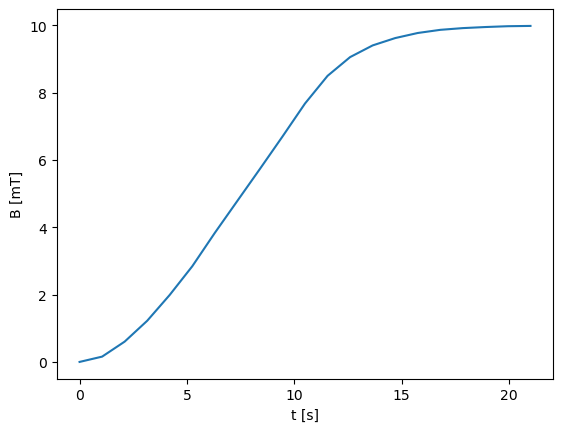

In [11]:
fig, ax = plt.subplots()
ax.plot(t,B_y*1e3)
ax.set_xlabel('t [s]')
ax.set_ylabel('B [mT]')

In [12]:
instrument.pause()
instrument.setpoint(0)

In [13]:
# Monitor the ramp
start_time = time.time()
trace_length = 21

t = np.linspace(0,trace_length,trace_length)
B_y = np.zeros(trace_length)
instrument.ramp()
for i in range(trace_length):
    time.sleep(1 - time.monotonic() % 1)
    B_y[i] = instrument.field.get()

Text(0, 0.5, 'B [mT]')

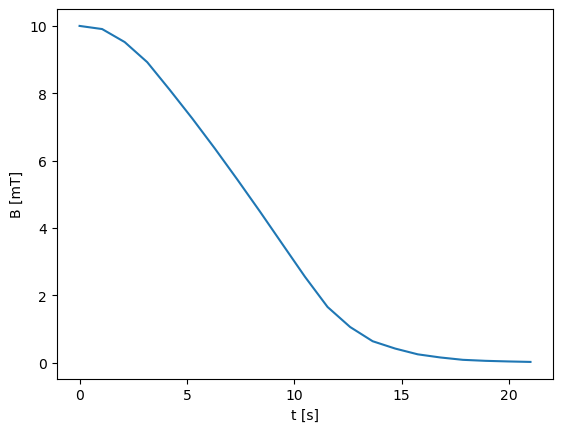

In [14]:
fig, ax = plt.subplots()
ax.plot(t,B_y*1e3)
ax.set_xlabel('t [s]')
ax.set_ylabel('B [mT]')

In [22]:
#Now we write a function to automate a single sweep 


def perform_sweep(instrument, target_field,trace_length=21):
    instrument.pause()
    instrument.setpoint.set(target_field)

    start_time = time.time()
    trace_length = trace_length

    t = np.linspace(0,trace_length,trace_length)
    B_y = np.zeros(trace_length)
    instrument.ramp()
    for i in range(trace_length):
        time.sleep(1 - time.monotonic() % 1)
        B_y[i] = instrument.field.get()
    #Trace taking finished. Waiting for magnet to have
    # reached the hold state. 
    while instrument.ramping_state() != 'holding':
        time.sleep(1)
    # Set the field back to 0
    instrument.field.set(0)
    # Return the traces 
    return t,B_y
    

In [39]:
t,B_y = perform_sweep(instrument,0.01)

Text(0, 0.5, 'B [mT]')

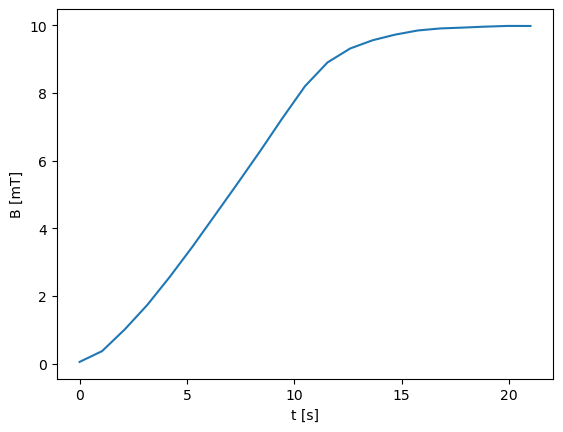

In [24]:
fig, ax = plt.subplots()
ax.plot(t,B_y*1e3)
ax.set_xlabel('t [s]')
ax.set_ylabel('B [mT]')

Testing stability paramter: 0.0
Check the stability parameter was set: 0.0
Testing stability paramter: 100.0
Check the stability parameter was set: 100.0


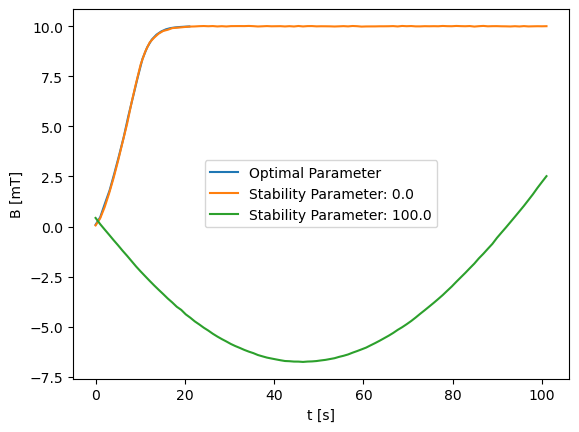

In [40]:
#Now we do a test, how does the stability parameter influence this field. 

fig, ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('B [mT]')
ax.plot(t,B_y*1e3,label = 'Optimal Parameter')

stability_parameter = np.linspace(0,100,2)    
for i in stability_parameter: 
    print('Testing stability paramter: {:.1f}'.format(i))
    instrument.stability_parameter.set(i)
    print('Check the stability parameter was set:', instrument.stability_parameter.get())
    ts,B_ys = perform_sweep(instrument,0.01,trace_length=101)
    ax.plot(ts,B_ys*1e3,label = 'Stability Parameter: {:.1f}'.format(i) )
ax.legend(loc='best')


Notes: From this we clearly see that the right calibration parameters have a hughe influence on reaching the field setpoint.

# Try o out some of the standard functions of the QCodes Driver:

In [43]:
instrument.field.get()

1.44e-07

In [44]:
instrument.pause()
instrument.setpoint.set(0.01)

In [45]:
instrument.ramp()
time.sleep(2)
instrument.pause()
print(instrument.ramping_state.get())
print(instrument.field.get())

paused
0.00054957


In [19]:
instrument.setpoint.get()

0.01

In [20]:
instrument.ramp()
time.sleep(5)
instrument.pause()
print(instrument.ramping_state.get())
print(instrument.field.get())

paused
0.002743609


In [21]:
instrument.zero()

In [25]:
instrument.field.get()
instrument.field.get()
instrument.ramping_state.get()

'at zero current'

In [28]:
instrument.setpoint.get()
instrument.ramping_state.get()
instrument.ramp()
for i in np.arange(31):
    time.sleep(1)
    print(instrument.field.get())
    print(instrument.ramping_state.get())


9.3224e-05
ramping
0.000598446
ramping
0.001393332
ramping
0.002355187
ramping
0.003433986
ramping
0.004557132
ramping
0.005741806
ramping
0.006903407
ramping
0.008072051
ramping
0.008889219
ramping
0.009359796
ramping
0.009636378
ramping
0.009800473
ramping
0.009881693
ramping
0.009945017
ramping
0.009963633
ramping
0.009984837
ramping
0.009995115
holding
0.009998709
holding
0.009994324
holding
0.009992815
holding
0.009997415
holding
0.009991952
holding
0.010005681
holding
0.010008412
holding
0.010002015
holding
0.01000604
holding
0.009997846
holding
0.010007981
holding
0.009999499
holding
0.010003596
holding


In [31]:
instrument.field.set(0)